<a href="https://www.kaggle.com/code/stanym/genai-powered-risk-and-financial-analysis-of-apple?scriptVersionId=235177929" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# GenAI-Powered Risk and Financial Analysis of Apple’s Q1 2025 10-Q 

## Objective: 
#### To help investors and individuals without a financial background understand risks from SEC filings using GenAI, leveraging Gemini as a foundational model to enhance the analysis and interpretation of complex financial data.


Key Highlights:
1. Extracts financial tables using Google GenAI prompts
2. Separates and chunks narrative text for sentiment & risk analysis
3. Embeds chunked text for search and classification using Google GenAI Embeddings
4. Generates structured output using agents, and a final PDF report
5. **Utilizes Gemini as a foundational model to enhance and update the capabilities of the system**

Gen AI Capabilities Demonstrated:
1. Structured output/JSON mode/controlled generation
2. Few-shot prompting
3. Document understanding
4. Image understanding
5. Function Calling
6. Agents
7. Long context window
8. Grounding
9. Embeddings
10. Retrieval augmented generation (RAG)
11. Vector search/vector store/vector database



## Setup

In [81]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -Uq "google-genai==1.7.0"

In [82]:
!pip install pdfplumber
!pip install google-cloud-discoveryengine
!pip install PyMuPDF
!pip install google-generativeai

In [83]:
from google import genai
from google.genai import types

from IPython.display import Markdown, display

genai.__version__

'1.7.0'

Setup local variables 

In [84]:
from kaggle_secrets import UserSecretsClient
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

## File Processing: Parsing, Chunking, Embedding, Vectors Storage and Similarity Search

Load the SEC report 2025-10-q
[**[source link]**](https://www.sec.gov/edgar/browse/?CIK=320193&owner=exclude)

In [85]:
!wget -nv -O 10Q_Q1_2025_as_filed.pdf https://storage.googleapis.com/cloud-raw-data/pdf/10Q_Q1_2025_as_filed.pdf

document_file = client.files.upload(file='10Q_Q1_2025_as_filed.pdf')

2025-04-21 06:57:33 URL:https://storage.googleapis.com/cloud-raw-data/pdf/10Q_Q1_2025_as_filed.pdf [424623/424623] -> "10Q_Q1_2025_as_filed.pdf" [1]


In [86]:
import pdfplumber
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import textwrap
import json

In [87]:
#Extract text (no tables), use pdfplumber to open the PDF and read each page
def raw_text_extraction(pdf_path):
    text_output = ''
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                text_output += text + '\n'
    return text_output

In [88]:
#Split text into chunks (approx. max_tokens tokens)
def split_into_chunks(text, max_tokens=300):
    approx_chunk_len = max_tokens * 4  # 1 token ~ 4 characters (roughly)
    paragraphs = text.split('\n\n')  # basic paragraph split
    chunks = []

    current_chunk = ''
    for para in paragraphs:
        if len(current_chunk) + len(para) < approx_chunk_len:
            current_chunk += para.strip() + ' '
        else:
            chunks.append(current_chunk.strip())
            current_chunk = para.strip() + ' '
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

In [89]:
# Embeddings are generated in the context of "QUESTION_ANSWERING"
def embed_chunks_with_genai(client, paragraphs):
    response = client.models.embed_content(
        model='models/text-embedding-004',
        contents=paragraphs,
        config={"task_type":"QUESTION_ANSWERING",}
    )
    return [embedding.values for embedding in response.embeddings]

In [90]:
# Store chunks+vectors in DataFrame 
def build_embedding_dataframe(chunks, embeddings):
    chunk_ids = [f'chunk{i+1}' for i in range(len(chunks))]
    df = pd.DataFrame({
        'chunk_id': chunk_ids,
        'text': chunks,
        'embedding': embeddings
    })
    return df

In [91]:
#Similarity Search using cosine
def search_similar_chunks(query, df, client, top_n=3):

    query_response = client.models.embed_content(
        model='models/text-embedding-004',
        contents=[query],
        config=types.EmbedContentConfig(
            task_type="QUESTION_ANSWERING",
        )
    )
    query_vector = query_response.embeddings[0].values
    embeddings_matrix = np.vstack(df['embedding'].values)
    
    similarities = cosine_similarity([query_vector], embeddings_matrix)[0]
    df['similarity'] = similarities
    return df.sort_values('similarity', ascending=False).head(top_n)

Utilizing the similarity search result and the initial query to generate a refined prompt, which is then being passed to Gemini for further processing.

In [92]:
def make_prompt(query, relevant_passage):
    escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")
    prompt = f"""
You are a financial risk analyst helping a non-technical audience understand potential risks faced by a company, based on excerpts from its official reports.

Read the passage below and extract any **risks** that are either clearly mentioned or implied. These may include:
- Financial risks (e.g., revenue decline, debt, liquidity)
- Operational risks (e.g., supply chain issues, product delays)
- Legal or regulatory risks
- Competitive risks
- Macroeconomic uncertainties (e.g., inflation, global demand)
- Reputational risks

Summarize these in **clear bullet points** or a short paragraph. Use plain English, and make it easy for someone without a finance background to understand. If no risk is found, say: *"No significant risks mentioned in this section."*

PASSAGE: {escaped}

ANSWER:
"""
    return prompt

Gemeni function calling

In [93]:
def generate_content(request: str) -> str:
  """You are a financial expert skilled"""
  # Set the temperature low to stabilise the output.
  config = types.GenerateContentConfig(temperature=0.0)
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=config,
      contents=[request],
  )
  
  return response.text

### Document Processing Function Invocation

In [94]:
pdf_path = '10Q_Q1_2025_as_filed.pdf'
clean_text = raw_text_extraction(pdf_path)
chunks = split_into_chunks(clean_text)

    
# Embed using your preferred GenAI method
embedded_vectors = embed_chunks_with_genai(client, chunks)

# Store in local DataFrame
df = build_embedding_dataframe(chunks, embedded_vectors)

### Report Summary Extraction on Embedded Data

In [95]:
# Define your financial risk extraction query
financial_risk_query ="From the Apple 10-Q report for Q1 2025, extract all paragraphs or sections that discuss financial performance"
"financial stability, cash flow, revenue, expenses, debt, or profitability. Also include any parts that mention"
"risks — such as legal risks, regulatory risks, supply chain disruptions, competitive risks, macroeconomic uncertainties, or litigation."

# Search for the most relevant document chunks
top_chunks = search_similar_chunks(financial_risk_query, df,client,1)
passage=top_chunks.iloc[0] #Finding the best passage from the embedded chunk
passage=passage['text']  #best passage text extraction
prompt = make_prompt(financial_risk_query, passage)
risk_analysis_text = generate_content(prompt) #Prompt based on the embedded data
Markdown(risk_analysis_text)

Here's a breakdown of the potential risks identified in the provided text:

*   **Macroeconomic Risks:** The report explicitly mentions that macroeconomic conditions, including inflation, interest rates, and currency fluctuations, could materially impact the company's results of operations and financial condition. This means that changes in the overall economy could negatively affect Apple's sales, profits, and financial stability.

*   **Competitive Risks & Legal/Regulatory Risks:** The company is subject to antitrust investigations and litigation in various jurisdictions, including a lawsuit by the U.S. Department of Justice alleging monopolization. Unfavorable outcomes could lead to significant fines and changes in business practices, negatively impacting the company's financial performance and reputation. The company is also subject to Digital Markets Act investigations in the EU, which could result in fines and changes to business practices.

*   **Legal/Regulatory Risks:** The company faces complex and changing laws and regulations worldwide, including those related to antitrust, privacy, data security, consumer protection, and environmental issues. Compliance with these laws is expensive, and violations could lead to liabilities, increased costs, and damage to the company's reputation.

*   **Revenue Decline Risk (Greater China):** Sales in Greater China decreased due to lower iPhone sales, indicating a potential risk of declining revenue in this important market.

*   **Currency Fluctuation Risk:** The company is exposed to foreign exchange rate risk, which can impact gross margins and the value of foreign currency-denominated assets and liabilities. While the company uses hedging strategies, there's no guarantee these will fully offset the impact of currency movements.

*   **Gross Margin Volatility:** The report states that future gross margins can be impacted by a variety of factors and are expected to be subject to volatility and downward pressure. This suggests a risk of declining profitability on sales.

*   **Customer Concentration Risk:** Two customers represent a significant portion of total trade receivables, indicating a risk if either of these customers were to experience financial difficulties or reduce their business with Apple. Similarly, two vendors represent a significant portion of total vendor non-trade receivables.

*   **Product Introduction Risk:** The timing of new product introductions can impact net sales, and sales can be affected when consumers anticipate a product introduction. This suggests a risk of sales fluctuations based on product cycles.

*   **Reliance on Licensing Arrangements:** The company earns revenue from licensing arrangements with Google and other companies, and changes to these arrangements due to government investigations and legal proceedings could materially adversely affect the company's ability to earn revenue.


## Table Extraction

Text and tables are processed as distinct entities, where raw text is directly embedded, whereas tables are handled separately due to their structured format, requiring specialized processing to extract and utilize their contents effectively.


In [96]:
# Prompt template to extract structured table data
def build_prompt(page_number, page_text):
    return (
        f"You are a financial data analyst expert at extracting structured data from SEC 10-Q filings.\n"
        f"This is page {page_number} of the Apple 10-Q report:\n\n"
        f"{page_text}\n\n"
        " Extract only **financial tables** in this page.\n\n"
        " Important: Preserve the **hierarchy of rows** such as:\n"
        "- Main headers like 'ASSETS', 'LIABILITIES'\n"
        "- Subgroups like 'Current assets', 'Non-current assets'\n"
        "- Line items under each group (e.g., 'Cash and cash equivalents')\n\n"
        " Return result as valid nested JSON using this format:\n"
        "{\n"
        "  \"page_number\": <int>,\n"
        "  \"tables\": [\n"
        "     {\n"
        "       \"table_number\": <int>,\n"
        "       \"title\": \"<table title>\",\n"
        "       \"data\": {\n"
        "         \"ASSETS\": {\n"
        "           \"Current assets\": {\n"
        "             \"Cash and cash equivalents\": [\"$30,299\", \"$29,943\"],\n"
        "             ...\n"
        "           },\n"
        "           \"Non-current assets\": { ... },\n"
        "           \"Total assets\": [\"$344,085\", \"$364,980\"]\n"
        "         }\n"
        "       }\n"
        "     }\n"
        "  ]\n"
        "}"
    )

In [97]:
# Extract tables from each page
config = types.GenerateContentConfig(temperature=0.0)

def generate_table_json_from_page(prompt: str) -> dict:
    try:
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            config=config,
            contents=[prompt],
        )
        # Try to extract just the JSON from the text
        import re, json
        match = re.search(r"\{[\s\S]+\}", response.text)
        if match:
            return json.loads(match.group())
    except Exception as e:
        print("Error:", e)
    return None


Processing each page to extract tables, and then converting the extracted data into JSON format to facilitate visualization and further analysis.

In [98]:
import pdfplumber

all_pages_json = []
#pdf_path = "/kaggle/input/your-sec-pdf/apple_2025_10q.pdf"

with pdfplumber.open(pdf_path) as pdf:
    for i, page in enumerate(pdf.pages):
        page_number = i + 1
        page_text = page.extract_text()
        
        if not page_text or len(page_text.strip()) < 50:
            continue  # Skip empty or too-short pages
        
        print(f"Processing page {page_number}...")

        prompt = build_prompt(page_number, page_text)
        page_result = generate_table_json_from_page(prompt)

        if page_result:
            all_pages_json.append(page_result)
        else:
            print(f"Page {page_number} failed to extract - no table found.")
#print(all_pages_json)

Processing page 1...
Processing page 2...
Processing page 3...
Processing page 4...
Processing page 5...
Processing page 6...
Processing page 7...
Processing page 8...
Processing page 9...
Processing page 10...
Processing page 11...
Processing page 12...
Processing page 13...
Processing page 14...
Processing page 15...
Processing page 16...
Processing page 17...
Processing page 18...
Processing page 19...
Processing page 20...
Processing page 21...
Processing page 22...
Processing page 23...
Processing page 24...
Processing page 25...
Processing page 26...
Processing page 27...
Processing page 28...
Processing page 29...
Processing page 30...
Page 30 failed to extract - no table found.
Processing page 31...
Processing page 32...
Processing page 33...
Page 33 failed to extract - no table found.
Processing page 34...
Page 34 failed to extract - no table found.
Processing page 35...
Processing page 36...
Page 36 failed to extract - no table found.
Processing page 37...
Processing page 38.

### Metric Data Extraction
The FinancialAnalysisAgent utilizes also Gemini 2.0 as foundation generative model to extract 
structure financial metrics from table-like content for visualization.

          +---------------+
          |  S0: Init     |
          +---------------+
                  |
                  |  Initialize
                  |  agent and receive
                  |  query and content
                  v
          +---------------+
          |  S3: Process  |
          |  Request      |
          +---------------+
                  |
                  |  Extract financial
                  |  metrics from content
                  v
          +---------------+
          |  S1: Extract  |
          |  Metrics      |
          +---------------+
                  |
                  |  Structure extracted
                  |  data for visualization
                  v
          +---------------+
          |  S2: Data     |
          |  Structuring  |
          +---------------+
                  |
                  |  Query matches a
                  |  specific type
                  v
          +-------------------+
          |  S4: Visualization|
          +-------------------+
                  |
                  |  Visualization fails
                  |  or data is empty
                  v
          +---------------+
          |  S5: Error    |
          |  Handling     |
          +---------------+
                  |
                  |  Reset agent and
                  |  restart process
                  v
          +---------------+
          |  S0: Init     |
          +---------------+


In [99]:
import google.generativeai as genai
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
from typing import Dict, Any


class FinancialAnalysisAgent:
    def __init__(self, api_key: str):
        genai.configure(api_key=api_key)
        self.model = genai.GenerativeModel("gemini-2.0-flash")

    def extract_metrics(self, query: str, content: str) -> Dict:
    # Use a chain-of-thought (step-by-step) structured prompt
        prompt = f"""
        You are a financial analysis assistant.

        Your job is to extract **financial metric data** from the following content for **multiple time periods**, available in the content.

        Step-by-step:
        1. Read the user's query: "{query}"
        2. Find the matching rows in the table-like content.
        3. Extract values for **each year or quarter**, including all the available years.
        4. Return a **valid JSON dictionary**, formatted like:
        {{
            "Q1 2024": {{
                "Product A": 150,
                "Product B": 200
            }},
            "Q1 2023": {{
                "Product A": 140,
                "Product B": 180
            }}
        }}

        Rules:
        - Include all the available years.
        _ use '-' as time separator
        - Do not include "Total", "Percentage change", or summary rows.
        - Ensure all numbers are cleanly parsed.

        Here is the table data:
        {content}
        """
        response = self.model.generate_content(prompt)
        try:
            match = re.search(r"\{.*\}", response.text, re.DOTALL)
            return json.loads(match.group()) if match else {}
        except Exception as e:
            print(" Error parsing model output to JSON:", e)
            return {}


    def data_structuring(self, data: Dict):
        if not data:
            print("No revenue data found.")
            return None
        try:
            return data
        except Exception as e:
            print("Error:", e)
            return None

    
    def process_request(self, query: str, content: str):
        metrics = self.extract_metrics(query, content)

        if "revenue by product" in query.lower():
            return self.data_structuring(metrics)
        elif "net income trend" in query.lower():
            return self.data_structuring(metrics)
        elif "cash flow" in query.lower():
            return self.data_structuring(metrics)
        elif "assets vs liabilities" in query.lower():
            return self.data_structuring(metrics)
        elif "revenue by geography" in query.lower():
            return self.data_structuring(metrics)
        else:
            print("No matching visualization found for the query.")


Testing the Agent

In [100]:
# Run the agent
finacial_metric_agent = FinancialAnalysisAgent(api_key=GOOGLE_API_KEY)

# Ask the agent to visualize revenue by product from Q1 2025
query = "Revenue by product for Apple in 2025"
revenue_by_product=finacial_metric_agent.process_request(query, content=all_pages_json)
print(revenue_by_product)

#query = "net income trend for Apple in Q1 2025"
#net_income_trend=agent.process_request(query, content=all_pages_json)
#print(net_income_trend)

#query = "assets vs liabilities for Apple in Q1 2025"
#assets_vs_liabilities=agent.process_request(query, content=all_pages_json)
#print(assets_vs_liabilities)

#query = "revenue by geography for Apple in 2024 and 2023"
#revenue_by_geography=agent.process_request(query, content=all_pages_json)
#print(revenue_by_geography)


{'December 28-2024': {'iPhone': '69,138', 'Mac': '8,987', 'iPad': '8,088', 'Wearables, Home and Accessories': '11,747', 'Services': '26,340'}, 'December 30-2023': {'iPhone': '69,702', 'Mac': '7,780', 'iPad': '7,023', 'Wearables, Home and Accessories': '11,953', 'Services': '23,117'}}


## Ploting Agent

Called **GenaiPlottingAgent** receives JSON data, generates plotting code using a Generative AI model, and executes it  to create the financial visualization of the data.

                                  +------------------+
                                  |  Initialization  |
                                  +------------------+
                                            |
                                            |  Start
                                            v
                                  +------------------+
                                  |  JSON Input      |
                                  +------------------+
                                            |
                                            |  JSON received
                                            v
                                  +-------------------+
                                  |  Prompt Creation  |
                                  +-------------------+
                                            |
                                            |  Prompt generated
                                            v
                                  +-------------------+
                                  |  Code Generation  |
                                  +-------------------+
                                            |
                                            |  Code generated
                                            v
                                  +-------------------+
                                  |  Code Execution   |
                                  +-------------------+
                                            |
                                            |  Code executed
                                            v
                                  +-------------------+
                                  |  Plot Display     |
                                  +-------------------+


In [101]:
import google.generativeai as genai
import json
from typing import Dict, Union, Any, Optional
import os
import matplotlib.pyplot as plt
import re
import ast
import warnings
# Now your plotting code
import seaborn as sns

# Suppress FutureWarnings globally (can be fine-tuned later)
warnings.simplefilter(action='ignore', category=FutureWarning)

class GenaiPlottingAgent:
    """
    A plotting agent powered by Google's Generative AI (Gemini).
    This agent takes JSON data as input and uses Gemini to generate
    appropriate plotting code which is then executed.
    """
   
    def __init__(self, api_key: Optional[str] = None):
        """
        Initialize the Genai Plotting Agent.
       
        Args:
            api_key: Google API key for Gemini access (optional if set as env var)
        """
        if api_key:
            genai.configure(api_key=api_key)
        else:
            genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

        self.model = genai.GenerativeModel('gemini-2.0-flash')  # You can use 'gemini-pro' or 'gemini-1.5-pro'
    def parse_json(self, json_input: Union[str, Dict]) -> Dict:
        """
        Parse JSON input to ensure we have a dictionary.
        """
        if isinstance(json_input, str):
            return json.loads(json_input)
        return json_input
   
    def generate_plot(self, json_data: Union[str, Dict]) -> None:
        """
        Generate a plot based on provided JSON data.
        """
        data = self.parse_json(json_data)
        prompt = self._create_plotting_prompt(data)
        config_with_code = types.GenerateContentConfig(
            tools=[types.Tool(code_execution=types.ToolCodeExecution())],
            temperature=0.0,
        )
    
        self.config = config_with_code
        response = self.model.generate_content(prompt)
        code = self._extract_code_from_response(response)
        
        if code:
            print("Executing generated plotting code...")
            try:
                # Parse the code using ast
                tree = ast.parse(code)
                # Execute the code
                exec(compile(tree, filename="<ast>", mode="exec"))
            except Exception as e:
                print(f"Error executing generated code: {e}")
                #print("\nGenerated code that caused the error:")
                #print(code)
                self.generate_plot(json_data)
        else:
            print("No valid plotting code was generated.")


   
    def _create_plotting_prompt(self, data: Dict) -> str:
        """
        Create a prompt for Gemini to generate plotting code.
        """
        # Automatically detect best plot type
        analysis = self.analyze_data(data)
        suggested_plot = analysis.get("plot_type", "line")
        data_str = json.dumps(data, indent=2)
        prompt = f"""
        You are a helpful Python plotting assistant. Generate **working, error-free** Python code to visualize the following JSON data using **matplotlib** and **seaborn**.
        
        ### INSTRUCTIONS:
        - First, parse the JSON into a Python dictionary.
        - considere plot type {suggested_plot}
        - Assume the outer keys are **date strings** (e.g., 'December 30-2023'), and inner keys are **categories or regions with numeric values**.
        - Convert the nested dictionary into a **pandas DataFrame** using `pd.DataFrame.from_dict(data, orient='index')` to simplify the transformation.
        - Set the DataFrame index to the date values (as strings).
        - Sort the index chronologically if needed for line plots.
        - Plot each column (category) as a line using a loop with `plt.plot(...)`.
        - Set appropriate axis labels, a title, and a legend.
        - Use `plt.xticks(rotation=45)` to rotate date labels for readability.
        - Use `plt.tight_layout()` to avoid layout overlap.
        - Use `plt.savefig(data) with data variable name`
        - Use `plt.show()` to display the plot.
        - **Avoid putting labels inside the plotting loop**.
        - Wrap the entire code in a single Python script block, inside triple backticks (```python).
        - **Do not output any explanation**, only the code.
        
        ### JSON Data to visualize:
        ```json
        {data_str}
            ```
                """
        return prompt

    def _extract_code_from_response(self, response) -> str:
        """
        Extract Python code from the Gemini model response.
       
        Args:
            response: Response from the Gemini model
           
        Returns:
            Extracted Python code as string
        """
        # Check if there's any code in the response
        if hasattr(response, 'text'):
            response_text = response.text
        else:
            # Handle different response structure
            response_text = str(response)
           
        # Extract code between triple backticks
        import re
        code_blocks = re.findall(r'```python(.*?)```', response_text, re.DOTALL)
       
        if code_blocks:
            return self._sanitize_code(code_blocks[0].strip())
       
        # If no code blocks with python tag, try without language specification
        code_blocks = re.findall(r'```(.*?)```', response_text, re.DOTALL)
        if code_blocks:
            return self._sanitize_code(code_blocks[0].strip())
       
        # If still no code blocks, return the whole response
        return self._sanitize_code(response_text.strip())

    def _sanitize_code(self, code: str) -> str:
        """
        Sanitize the generated code to ensure proper formatting.
        
        Args:
            code: The generated code as a string.
        
        Returns:
            Sanitized code as a string.
        """
        import textwrap
        return textwrap.dedent(code).strip()
      
    
    def analyze_data(self, json_data: Union[str, Dict]) -> Dict:
        """
        Use GenAI to analyze the structure of JSON data and select the best plot type.
        
        Args:
            json_data: The JSON data to analyze
        
        Returns:
            Dictionary with:
                - plot_type: Best recommended plot type (string)
                - reason: Explanation for the choice
        """
        data = self.parse_json(json_data)
        data_str = json.dumps(data, indent=2)
    
        prompt = f"""
    Analyze the following JSON data and return a JSON object with the most appropriate plot type for visualization.
    
    ### Instructions:
    - Return only a JSON object with the following keys:
      - "plot_type": the single best matplotlib/seaborn chart type for this data (e.g., "Time Series Plot", "line", "bar","Area Chart", "Histogram","heatmap", "scatter", "box").
      - "reason": a short explanation for choosing that plot type.
    - Do not return multiple plot types.
    - Do not include any explanation outside the JSON object.
    
    ### Data:
    ```json
    {data_str}
        ```
        """
        response = self.model.generate_content(prompt)
        
        try:
            response_text = response.text if hasattr(response, 'text') else str(response)
        
            json_match = re.search(r'```json(.*?)```', response_text, re.DOTALL)
            if json_match:
                response_text = json_match.group(1).strip()
        
            response_text = response_text.replace("```", "").strip()
            return json.loads(response_text)
        except Exception as e:
            return {
                "plot_type": "line",
                "reason": "Fallback: parsing error",
                "error": str(e),
                "raw_response": response.text if hasattr(response, 'text') else str(response)
            }

Sample Test on Revenue by Product

Executing generated plotting code...


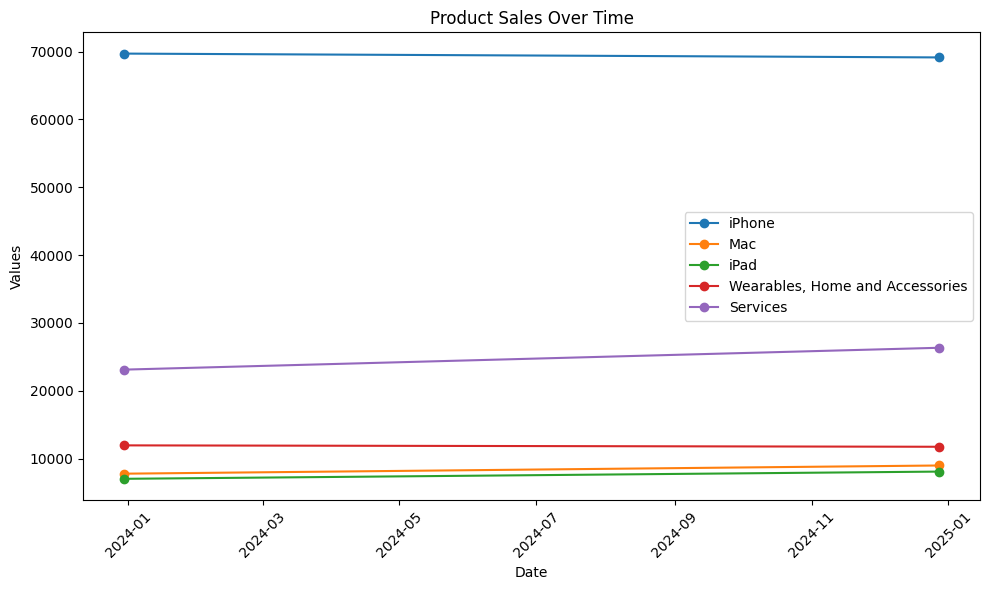

In [102]:
plot_agent = GenaiPlottingAgent(api_key=GOOGLE_API_KEY)
plot_agent.generate_plot(revenue_by_product)

## Image plot Intepreter Agent
Called **ImageInterpreterAgent**, takes plot image, interprets it using a Generative AI model, and generates text based on the plot image and a given prompt.

                                  +------------------+
                                  |  Initialization  |
                                  +------------------+
                                            |
                                            |  Model Loaded
                                            v
                                  +------------------+
                                  |  Image Input     |
                                  |  (image_path,    |
                                  |   prompt)        |
                                  +------------------+
                                            |
                                            |  Image Loaded
                                            v
                                  +------------------+
                                  |  Interpret Image |
                                  +------------------+
                                            |
                                            |  Text Generated
                                            v
                                  +-------------------+
                                  |  Text Generation  |
                                  +-------------------+
                                            |
                                            |  Text Returned
                                            v
                                  +--------------------+
                                  |  Text Output       |
                                  |  (interpreted text)|
                                  +--------------------+


In [103]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO

#use the modele availabe based on the region :
#gemini-2.0-flash-exp-image-generation gemini-2.5-flash-preview-04-17  gemini-1.5-flash-8b gemini-2.0-flash
class ImageInterpreterAgent:
    def __init__(self, model="gemini-2.0-flash-exp-image-generation"):
        self.client = genai.Client(api_key=GOOGLE_API_KEY)
        self.model = model

    def interpret_image(self, image_path: str, prompt: str):
        # Load the image
        image = Image.open(image_path)
        display(image)
        # Prepare request
        response = self.client.models.generate_content(
            model=self.model,
            contents=[prompt, image],
            config=types.GenerateContentConfig(
                response_modalities=['TEXT', 'IMAGE']
            )
        )

        # Process and return text as we're only interested in text
        answer=""
        for part in response.candidates[0].content.parts:
            if part.text:
                answer+= part.text + "\n"
        
        return answer.strip()


Test

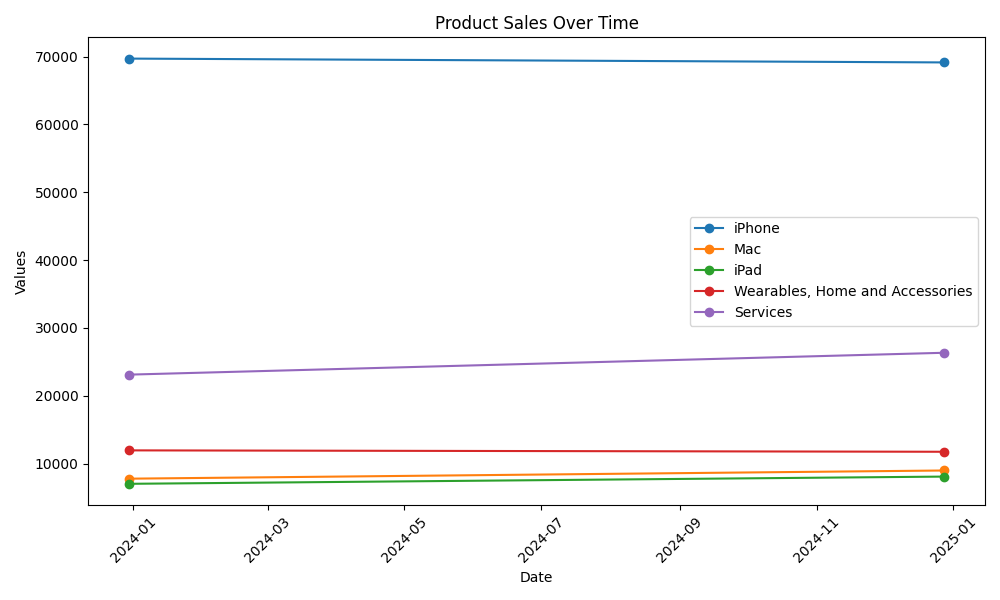

ClientError: 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-2.0-flash-exp-image-generation is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.', 'status': 'NOT_FOUND'}}

In [104]:
graphic_interpreter_agent = ImageInterpreterAgent()
intepretation1=graphic_interpreter_agent.interpret_image('/kaggle/working/data.png', "Explain shortly and summarize shortly lines max as a financial expert")
print(intepretation1)

#### Report Generation

Combine multiple sections with optional images, and then merges them into a single PDF file

In [105]:
!pip install markdown weasyprint PyPDF2

In [106]:
import markdown
from weasyprint import HTML
from PyPDF2 import PdfMerger
from IPython.display import FileLink, display
import base64
import os

class MarkdownToPDFBuilder:
    def __init__(self, output_pdf="combined_report.pdf"):
        self.section_pdfs = []
        self.output_pdf = output_pdf

    def add_section(self, title: str, text: str, image_path: str = None):
        # Markdown to HTML
        md_content = f"# {title}\n\n{text}"
        html_content = markdown.markdown(md_content)

        # Embed image if present
        if image_path:
            with open(image_path, "rb") as img_file:
                img_data = base64.b64encode(img_file.read()).decode("utf-8")
                img_tag = f'<img src="data:image/png;base64,{img_data}" style="max-width:50%; height:35%;">'
                html_content += f"<br>{img_tag}"

        # Wrap in full HTML
        full_html = f"<html><body>{html_content}</body></html>"

        # Create individual PDF
        temp_pdf = f"temp_section_{len(self.section_pdfs) + 1}.pdf"
        HTML(string=full_html).write_pdf(temp_pdf)
        self.section_pdfs.append(temp_pdf)

        print(f" Section added: {title}")

    def finalize(self):
        # Merge all section PDFs
        merger = PdfMerger()
        for pdf in self.section_pdfs:
            merger.append(pdf)
        merger.write(self.output_pdf)
        merger.close()
    
        abs_path = os.path.join("/kaggle/working/", self.output_pdf)
    
        print(f"\n Final PDF saved to: {abs_path}")
        
        # Show download link
        #display(FileLink(abs_path, result_html_prefix="Click to download: "))


    def cleanup(self):
        for f in self.section_pdfs:
            try:
                os.remove(f)
                #print(f"Deleted: {f}")
            except Exception as e:
                print(f" Could not delete {f}: {e}")


## Main Execution
Generating a financial report, including risk analysis, revenue by product, net income trend, and assets vs liabilities all the plot possible by using various agents, financial metric, plot, and interpretation agents, to process and visualize the data continuously.

 Section added: Risk Report
Executing generated plotting code...


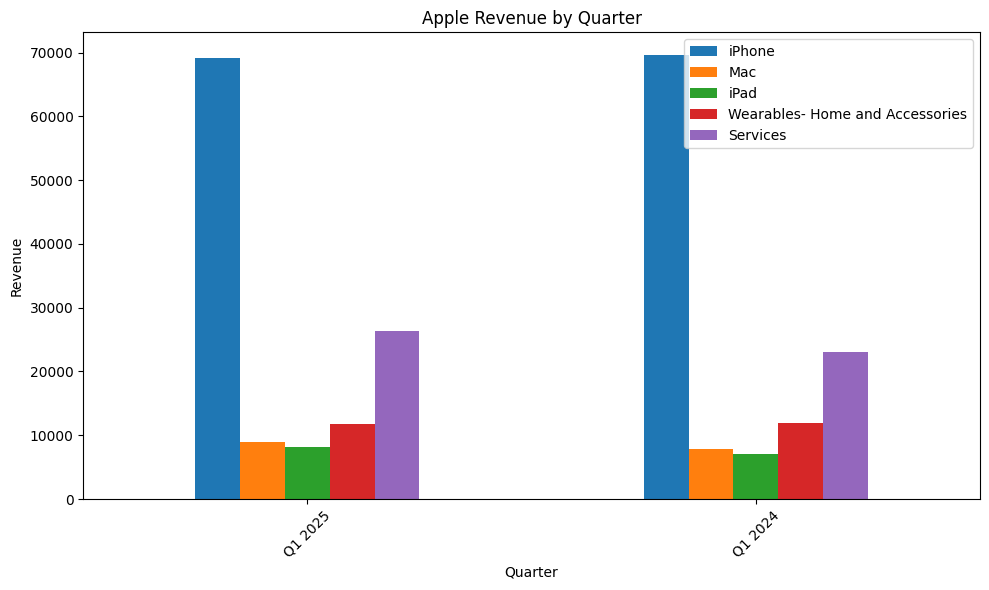

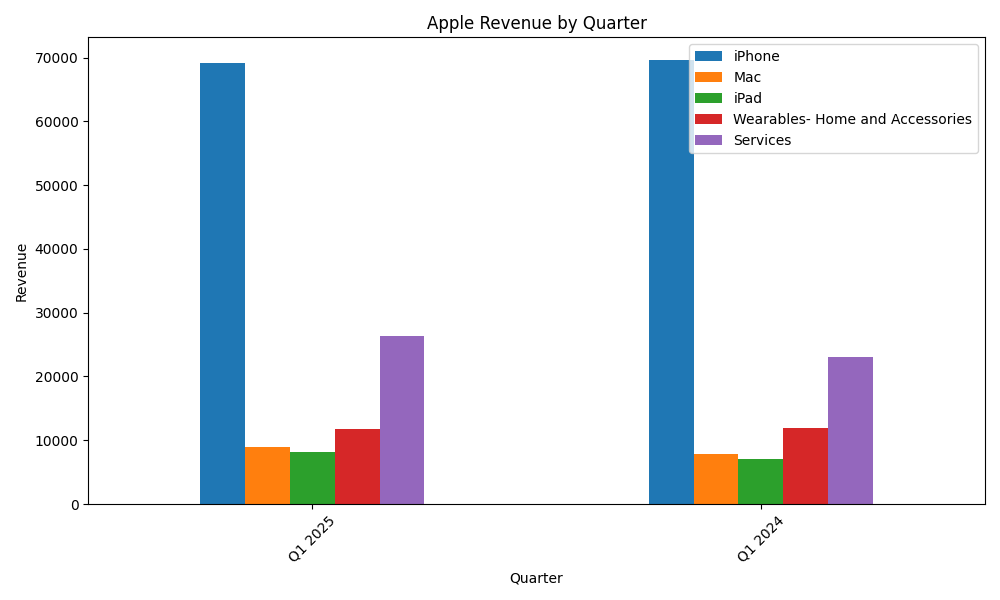

ClientError: 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-2.0-flash-exp-image-generation is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.', 'status': 'NOT_FOUND'}}

In [107]:
builder = MarkdownToPDFBuilder() #report builder
builder.add_section("Risk Report", risk_analysis_text)
graphic_prompt="""You are a financial expert. Analyze, explain, and summarize the value changes shown in the plot. 
Your audience has no finance background,so keep your explanation clear and simple. 
Focus only on the key information and provide essential reasons behind the changes — not too detailed, 
but enough to understand the important trends and what might be causing them."""
#FINANCIAL ANALYSYS AGENT instance
#finacial_metric_agent used on the top

#PLOTING AGENT instance
#plot_agent = usend on the top

#ITEPRETING AGENT instance
#graphic_interpreter_agent used on the top

# Processing revenue by product from Q1 2024
query = "Revenue by product for Apple in 2024"
revenue_by_product=finacial_metric_agent.process_request(query, content=all_pages_json)
plot_agent.generate_plot(revenue_by_product)
revenue_by_product_intepretation=graphic_interpreter_agent.interpret_image('/kaggle/working/data.png',graphic_prompt)
builder.add_section("Revenue Report", revenue_by_product_intepretation, "data.png")

# Processing revenue by product from Q1 2024
query = "Net income trend for Apple in Q1 2025"
net_income_trend=finacial_metric_agent.process_request(query, content=all_pages_json)
plot_agent.generate_plot(net_income_trend)
net_income_trend_intepretation=graphic_interpreter_agent.interpret_image('/kaggle/working/data.png',graphic_prompt)
builder.add_section("Net income Trend", revenue_by_product_intepretation, "data.png")


query = "Assets vs liabilities for Apple in Q1 2025"
assets_vs_liabilities=finacial_metric_agent.process_request(query, content=all_pages_json)
plot_agent.generate_plot(assets_vs_liabilities)
net_income_trend_intepretation=graphic_interpreter_agent.interpret_image('/kaggle/working/data.png',graphic_prompt)
builder.add_section("Assets vs liabilities", net_income_trend_intepretation, "data.png")


builder.finalize()
builder.cleanup()

## REFERENCES
[Google AI](http://https://ai.google.dev/gemini-api/docs/models)

**Finite State Machines in Hardware:** Theory and Design (with VHDL and SystemVerilog) by Volnei A. Pedroni.

**Synthesis of Finite State Machines:** Logic Optimization by Tiziano Villa, Timothy Kam, Robert K. Brayton, and Alberto L. Sangiovanni-Vincentelli.

**Digital Design and Computer Architecture by David Harris and Sarah Harris**.

**Introduction to Automata Theory, Languages, and Computation** by John E. Hopcroft, Rajeev Motwani, and Jeffrey D. Ullman (covers FSM concepts extensively).

**The Essentials of Risk Management** by Michel Crouhy, Dan Galai, and Robert Mark.

**Financial Risk Management Fundamentals** by Jason Schenker.

**Risk Management and Financial Institutions** by John C. Hull.